# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [2]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [5]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.410
adam: Epoch 4 Loss 0.273
adam: Epoch 6 Loss 0.236
adam: Epoch 8 Loss 0.212
adam: Epoch 10 Loss 0.188
adam: Epoch 12 Loss 0.178
adam: Epoch 14 Loss 0.166
adam: Epoch 16 Loss 0.162
adam: Epoch 18 Loss 0.159
adam: Epoch 20 Loss 0.154


Text(0.5, 1.0, 'MNIST')

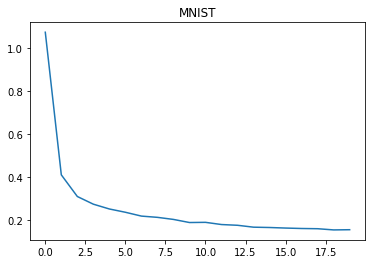

In [6]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [7]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [8]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.25


,0,1,2,3,4,5,6,7,8,9
0,97.142857,0.000000,0.918367,0.000000,0.000000,0.408163,1.224490,0.204082,0.000000,0.102041
1,0.000000,97.533040,0.176211,0.352423,0.176211,0.000000,0.176211,0.264317,1.321586,0.000000
2,0.968992,0.484496,92.926357,1.259690,0.193798,0.096899,0.193798,1.937984,1.841085,0.096899
3,0.099010,0.099010,0.495050,95.445545,0.099010,1.188119,0.000000,1.386139,0.792079,0.396040
4,0.203666,0.000000,0.305499,0.000000,94.806517,0.000000,1.120163,0.509165,0.101833,2.953157
5,0.560538,0.448430,0.112108,3.811659,0.000000,90.919283,0.896861,0.224215,2.130045,0.896861
6,0.835073,0.521921,0.104384,0.000000,0.626305,0.835073,96.346555,0.104384,0.626305,0.000000
7,0.194553,0.875486,1.459144,1.848249,0.583658,0.097276,0.000000,92.607004,0.194553,2.140078
8,0.205339,0.924025,0.924025,1.745380,0.924025,1.334702,1.129363,0.102669,91.991786,0.718686
9,0.891972,0.495540,0.000000,0.891972,2.775025,0.693756,0.000000,1.585728,0.495540,92.170466


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 2.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [9]:
#MNIST EXPERIMENT 1
n_hiddens_per_conv_layer = [10]
patch_size_per_conv_layer = [5]
stride_per_conv_layer=[2]
n_hiddens_per_fc_layer = [10]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

results = []

sub_result = []
sub_result.append(n_hiddens_per_conv_layer)
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnnet.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results.append(sub_result)

adam: Epoch 2 Loss 0.342
adam: Epoch 4 Loss 0.242
adam: Epoch 6 Loss 0.191
adam: Epoch 8 Loss 0.166
adam: Epoch 10 Loss 0.158
adam: Epoch 12 Loss 0.140
adam: Epoch 14 Loss 0.126
adam: Epoch 16 Loss 0.126
adam: Epoch 18 Loss 0.116
adam: Epoch 20 Loss 0.129
Test accuracy in percent correct: 95.71
Train accuracy in percent correct: 96.34


In [10]:
#MNIST EXPERIMENT 2
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer=[2, 2]
n_hiddens_per_fc_layer = [10]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result = []
sub_result.append(n_hiddens_per_conv_layer)
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnnet.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results.append(sub_result)

adam: Epoch 2 Loss 0.239
adam: Epoch 4 Loss 0.138
adam: Epoch 6 Loss 0.116
adam: Epoch 8 Loss 0.108
adam: Epoch 10 Loss 0.099
adam: Epoch 12 Loss 0.102
adam: Epoch 14 Loss 0.091
adam: Epoch 16 Loss 0.087
adam: Epoch 18 Loss 0.090
adam: Epoch 20 Loss 0.090
Test accuracy in percent correct: 96.42
Train accuracy in percent correct: 97.43


In [11]:
#MNIST EXPERIMENT 3
n_hiddens_per_conv_layer = [10, 10, 10]
#HAD TO CHANGE PATCH SIZE FROM [5, 5, 5]
patch_size_per_conv_layer = [4, 4, 4]
stride_per_conv_layer=[2, 2, 2]
n_hiddens_per_fc_layer = [10]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result = []
sub_result.append(n_hiddens_per_conv_layer)
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnnet.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results.append(sub_result)

adam: Epoch 2 Loss 0.288
adam: Epoch 4 Loss 0.190
adam: Epoch 6 Loss 0.155
adam: Epoch 8 Loss 0.138
adam: Epoch 10 Loss 0.132
adam: Epoch 12 Loss 0.131
adam: Epoch 14 Loss 0.122
adam: Epoch 16 Loss 0.114
adam: Epoch 18 Loss 0.114
adam: Epoch 20 Loss 0.117
Test accuracy in percent correct: 96.03
Train accuracy in percent correct: 96.77


In [12]:
#MNIST EXPERIMENT RESULTS 1
#print(results)
#NOTE: HAD TO CHANGE PATCH SIZE FOR [10, 10, 10] NETWORK
MNIST_results = pandas.DataFrame(results)
MNIST_results.columns = ['Network Structure', 'Test Percent Correct', 'Train percent Correct']
print(MNIST_results)
#FOUND [10, 10] NETWORK TO HAVE BEST TEST PERCENT CORRECT

  Network Structure  Test Percent Correct  Train percent Correct
0              [10]                 95.71                 96.344
1          [10, 10]                 96.42                 97.428
2      [10, 10, 10]                 96.03                 96.770


In [13]:
#MNIST EXPERIMENT 4
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer=[2, 2]
n_hiddens_per_fc_layer = []

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

results2 = []

sub_result2 = []
sub_result2.append(n_hiddens_per_fc_layer)
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result2.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnnet.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result2.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results2.append(sub_result2)

adam: Epoch 2 Loss 0.181
adam: Epoch 4 Loss 0.106
adam: Epoch 6 Loss 0.078
adam: Epoch 8 Loss 0.065
adam: Epoch 10 Loss 0.064
adam: Epoch 12 Loss 0.060
adam: Epoch 14 Loss 0.051
adam: Epoch 16 Loss 0.049
adam: Epoch 18 Loss 0.047
adam: Epoch 20 Loss 0.046
Test accuracy in percent correct: 97.38
Train accuracy in percent correct: 98.44


In [14]:
#MNIST EXPERIMENT 5
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer=[2, 2]
n_hiddens_per_fc_layer = [10]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result2 = []
sub_result2.append(n_hiddens_per_fc_layer)
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result2.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnnet.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result2.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results2.append(sub_result2)

adam: Epoch 2 Loss 0.233
adam: Epoch 4 Loss 0.145
adam: Epoch 6 Loss 0.124
adam: Epoch 8 Loss 0.112
adam: Epoch 10 Loss 0.104
adam: Epoch 12 Loss 0.098
adam: Epoch 14 Loss 0.099
adam: Epoch 16 Loss 0.092
adam: Epoch 18 Loss 0.090
adam: Epoch 20 Loss 0.086
Test accuracy in percent correct: 96.57
Train accuracy in percent correct: 97.59


In [15]:
#MNIST EXPERIMENT 6
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer=[2, 2]
n_hiddens_per_fc_layer = [10, 10]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result2 = []
sub_result2.append(n_hiddens_per_fc_layer)
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result2.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnnet.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result2.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results2.append(sub_result2)

adam: Epoch 2 Loss 0.316
adam: Epoch 4 Loss 0.192
adam: Epoch 6 Loss 0.157
adam: Epoch 8 Loss 0.144
adam: Epoch 10 Loss 0.139
adam: Epoch 12 Loss 0.119
adam: Epoch 14 Loss 0.120
adam: Epoch 16 Loss 0.115
adam: Epoch 18 Loss 0.104
adam: Epoch 20 Loss 0.106
Test accuracy in percent correct: 96.04
Train accuracy in percent correct: 97.21


In [16]:
#MNIST EXPERIMENT RESULTS 2
#print(results2)
print('Results for part 1:')
print(MNIST_results)
print('Results for part 2:')
MNIST_results2 = pandas.DataFrame(results2)
MNIST_results2.columns = ['Network Structure', 'Test Percent Correct', 'Train percent Correct']
print(MNIST_results2)
#FOUND [] NETWORK TO HAVE BEST TEST PERCENT CORRECT

Results for part 1:
  Network Structure  Test Percent Correct  Train percent Correct
0              [10]                 95.71                 96.344
1          [10, 10]                 96.42                 97.428
2      [10, 10, 10]                 96.03                 96.770
Results for part 2:
  Network Structure  Test Percent Correct  Train percent Correct
0                []                 97.38                 98.438
1              [10]                 96.57                 97.594
2          [10, 10]                 96.04                 97.212


## CNN2D Results Discussion

Part 1:

The network I found to have the best test accuracy was one with 2 convolutional layers, with an accuracy of 96.42 percent correct on the test data.  The one and three convolutional layer networks had 95.71 and 96.03 percent correct on the test data respectively.  Although the directions were to use a patch size of 5, I was unable to get a 3 convolutional layer network to work with a patch size of 5, so I used a patch size of 4 instead to get it to work.  Overall the difference in test percent correct between the networks was rather small, ranging from 0.39 to 0.71 percent.

Part 2:

The network I found to have the best test accuracy for part 2 was the network with zero fully-connected layers, with a test accuracy of 97.38 percent.  The second best network I had for part 2 was one with one fully-connected layer, with a test percent correct of 96.57. The worst network I had for part 2 was one with two fully-connected layers, with a test percent correct of 96.04.  The difference between the best network and other networks was much larger for this part, with the best network being a whole 0.81 percent better than the second best.  The other two networks were 0.53 percent apart. Overall the best network I trained had: n_hidden_per_conv_layer = [10, 10], patch_size_per_conv_layer = [5, 5], stride_per_conv_layer = [2, 2] and n_hiddens_per_fc_layer = [].

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `__init__` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately.
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [17]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        # original input image height (=width because image assumed square)
        input_hw = int((n_inputs))
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

        

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values, with zeros between the waves long.

In [18]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [19]:
make_square_pulse()

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

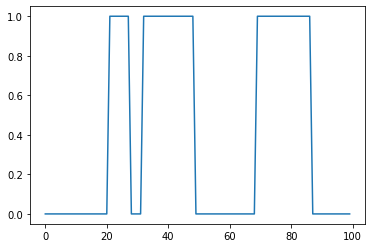

In [20]:
plt.plot(make_square_pulse());

In [21]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

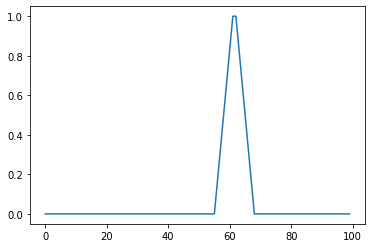

In [22]:
plt.plot(make_triangular_pulse());

In [23]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [24]:
np.newaxis == None

True

In [25]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [26]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.542
adam: Epoch 20 Loss 0.377
adam: Epoch 30 Loss 0.174
adam: Epoch 40 Loss 0.066
adam: Epoch 50 Loss 0.024
adam: Epoch 60 Loss 0.013
adam: Epoch 70 Loss 0.036
adam: Epoch 80 Loss 0.006
adam: Epoch 90 Loss 0.004
adam: Epoch 100 Loss 0.002


Text(0.5, 1.0, 'Pulses')

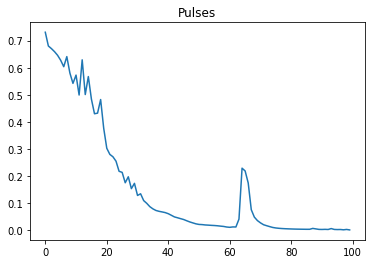

In [27]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [28]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 98.90


,square,triangular
square,97.8,2.2
triangular,0.0,100.0


torch.Size([10, 10])

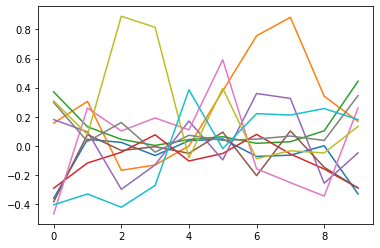

In [29]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~anderson/cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [30]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

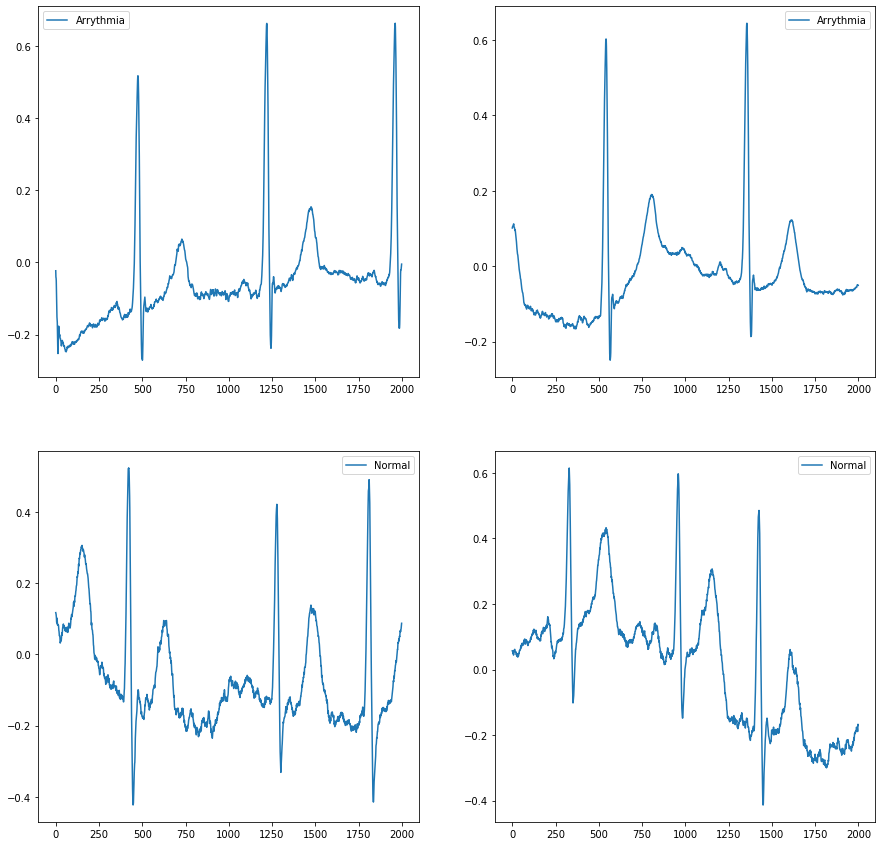

In [31]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [32]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [33]:
Ttrain

array([['nr'],
       ['nr'],
       ['nr'],
       ...,
       ['nr'],
       ['arr'],
       ['arr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [34]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [35]:
#ECG EXPERIMENT 1
n_hiddens_per_conv_layer = [5, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [10, 10]

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

results3 = []

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.660
adam: Epoch 4 Loss 0.571
adam: Epoch 6 Loss 0.528
adam: Epoch 8 Loss 0.480
adam: Epoch 10 Loss 0.406
adam: Epoch 12 Loss 0.366
adam: Epoch 14 Loss 0.420
adam: Epoch 16 Loss 0.287
adam: Epoch 18 Loss 0.229
adam: Epoch 20 Loss 0.223
Test accuracy in percent correct: 82.03
Train accuracy in percent correct: 89.69


In [36]:
#ECG EXPERIMENT 2
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer = [2, 2]
n_hiddens_per_fc_layer = [10, 10]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.671
adam: Epoch 4 Loss 0.670
adam: Epoch 6 Loss 0.670
adam: Epoch 8 Loss 0.670
adam: Epoch 10 Loss 0.670
adam: Epoch 12 Loss 0.670
adam: Epoch 14 Loss 0.670
adam: Epoch 16 Loss 0.670
adam: Epoch 18 Loss 0.670
adam: Epoch 20 Loss 0.670
Test accuracy in percent correct: 56.72
Train accuracy in percent correct: 60.74


In [37]:
#ECG EXPERIMENT 3
#TRYING BEST NETWORK FROM PART 1
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer = [2, 2]
n_hiddens_per_fc_layer = []


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.879
adam: Epoch 4 Loss 0.689
adam: Epoch 6 Loss 0.633
adam: Epoch 8 Loss 0.618
adam: Epoch 10 Loss 0.612
adam: Epoch 12 Loss 0.607
adam: Epoch 14 Loss 0.604
adam: Epoch 16 Loss 0.601
adam: Epoch 18 Loss 0.598
adam: Epoch 20 Loss 0.594
Test accuracy in percent correct: 62.24
Train accuracy in percent correct: 69.65


In [38]:
#ECG EXPERIMENT 4
#TRYING TO IMPROVE ECG NETWORK 2
n_hiddens_per_conv_layer = [10, 10, 10]
patch_size_per_conv_layer = [5, 5, 5]
stride_per_conv_layer = [2, 2, 2]
n_hiddens_per_fc_layer = [10, 10, 10]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.656
adam: Epoch 4 Loss 0.653
adam: Epoch 6 Loss 0.644
adam: Epoch 8 Loss 0.648
adam: Epoch 10 Loss 0.637
adam: Epoch 12 Loss 0.635
adam: Epoch 14 Loss 0.631
adam: Epoch 16 Loss 0.635
adam: Epoch 18 Loss 0.629
adam: Epoch 20 Loss 0.625
Test accuracy in percent correct: 61.83
Train accuracy in percent correct: 64.80


In [39]:
#ECG EXPERIMENT 5
n_hiddens_per_conv_layer = [10, 20]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [50, 50]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.643
adam: Epoch 4 Loss 0.568
adam: Epoch 6 Loss 0.522
adam: Epoch 8 Loss 0.388
adam: Epoch 10 Loss 0.319
adam: Epoch 12 Loss 0.238
adam: Epoch 14 Loss 0.132
adam: Epoch 16 Loss 0.177
adam: Epoch 18 Loss 0.159
adam: Epoch 20 Loss 0.057
Test accuracy in percent correct: 85.41
Train accuracy in percent correct: 97.71


In [40]:
#ECG EXPERIMENT 6: TRYING THE PROVIDED ARCHITECTURE WITH MORE HIDDENS PER FC
n_hiddens_per_conv_layer = [5, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [100, 100]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.680
adam: Epoch 4 Loss 0.674
adam: Epoch 6 Loss 0.613
adam: Epoch 8 Loss 0.621
adam: Epoch 10 Loss 0.566
adam: Epoch 12 Loss 0.454
adam: Epoch 14 Loss 0.400
adam: Epoch 16 Loss 0.347
adam: Epoch 18 Loss 0.283
adam: Epoch 20 Loss 0.204
Test accuracy in percent correct: 85.16
Train accuracy in percent correct: 92.89


In [41]:
#ECG EXPERIMENT 7: TRYING WITH MORE HIDDENS PER CONV
n_hiddens_per_conv_layer = [50, 100]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [100, 100]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.709
adam: Epoch 4 Loss 0.667
adam: Epoch 6 Loss 0.644
adam: Epoch 8 Loss 0.622
adam: Epoch 10 Loss 0.585
adam: Epoch 12 Loss 0.553
adam: Epoch 14 Loss 0.470
adam: Epoch 16 Loss 0.465
adam: Epoch 18 Loss 0.413
adam: Epoch 20 Loss 0.386
Test accuracy in percent correct: 74.36
Train accuracy in percent correct: 82.72


In [42]:
#ECG EXPERIMENT 8: TRYING WITH LESS PATCH SIZE
n_hiddens_per_conv_layer = [5, 10]
patch_size_per_conv_layer = [50, 10]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [100, 100]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.648
adam: Epoch 4 Loss 0.624
adam: Epoch 6 Loss 0.613
adam: Epoch 8 Loss 0.582
adam: Epoch 10 Loss 0.552
adam: Epoch 12 Loss 0.566
adam: Epoch 14 Loss 0.475
adam: Epoch 16 Loss 0.459
adam: Epoch 18 Loss 0.474
adam: Epoch 20 Loss 0.300
Test accuracy in percent correct: 81.53
Train accuracy in percent correct: 88.85


In [43]:
#ECG EXPERIMENT 9: TRYING WITH MORE PATCH SIZE
n_hiddens_per_conv_layer = [5, 10]
patch_size_per_conv_layer = [400, 80]
stride_per_conv_layer = [20, 5]
n_hiddens_per_fc_layer = [100, 100]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.677
adam: Epoch 4 Loss 0.599
adam: Epoch 6 Loss 0.483
adam: Epoch 8 Loss 0.391
adam: Epoch 10 Loss 0.320
adam: Epoch 12 Loss 0.296
adam: Epoch 14 Loss 0.241
adam: Epoch 16 Loss 0.188
adam: Epoch 18 Loss 0.174
adam: Epoch 20 Loss 0.158
Test accuracy in percent correct: 75.60
Train accuracy in percent correct: 92.89


In [44]:
#ECG EXPERIMENT 10: TRYING WITH LESS STRIDE
n_hiddens_per_conv_layer = [5, 10]
patch_size_per_conv_layer = [100, 20]
stride_per_conv_layer = [10, 2]
n_hiddens_per_fc_layer = [100, 100]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.685
adam: Epoch 4 Loss 0.638
adam: Epoch 6 Loss 0.532
adam: Epoch 8 Loss 0.478
adam: Epoch 10 Loss 0.370
adam: Epoch 12 Loss 0.343
adam: Epoch 14 Loss 0.332
adam: Epoch 16 Loss 0.274
adam: Epoch 18 Loss 0.178
adam: Epoch 20 Loss 0.243
Test accuracy in percent correct: 68.10
Train accuracy in percent correct: 86.45


In [45]:
#ECG EXPERIMENT 11: FREE FOR ALL!
n_hiddens_per_conv_layer = [5*2, 10*2, 10*2]
patch_size_per_conv_layer = [100, 10, 10]
stride_per_conv_layer = [20, 5, 5]
n_hiddens_per_fc_layer = [100, 100, 100]


n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnn1d = CNN1D(Xtrain.shape[-1], n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, 2, patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

sub_result3 = []
sub_result3.append(n_hiddens_per_conv_layer)
sub_result3.append(patch_size_per_conv_layer)
sub_result3.append(stride_per_conv_layer)
sub_result3.append(n_hiddens_per_fc_layer)
Classes, _ = cnn1d.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
sub_result3.append(perc_correct)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
Classes, _ = cnn1d.use(Xtrain)
perc_correct = 100 * np.mean(Classes == Ttrain)
sub_result3.append(perc_correct)
print(f'Train accuracy in percent correct: {perc_correct:.2f}')
results3.append(sub_result3)

adam: Epoch 2 Loss 0.673
adam: Epoch 4 Loss 0.626
adam: Epoch 6 Loss 0.581
adam: Epoch 8 Loss 0.514
adam: Epoch 10 Loss 0.479
adam: Epoch 12 Loss 0.377
adam: Epoch 14 Loss 0.381
adam: Epoch 16 Loss 0.290
adam: Epoch 18 Loss 0.306
adam: Epoch 20 Loss 0.258
Test accuracy in percent correct: 80.54
Train accuracy in percent correct: 89.77


In [46]:
#ECG EXPERIMENT RESULTS
MNIST_results3 = pandas.DataFrame(results3)
MNIST_results3.columns = ['Hiddens Per Conv Layer', 'Patch Size', 'Stride', 'Hiddens per FC Layer', 'Test % Correct', 'Train % Correct']
print(MNIST_results3)

   Hiddens Per Conv Layer     Patch Size      Stride Hiddens per FC Layer  \
0                 [5, 10]      [100, 20]     [20, 5]             [10, 10]   
1                [10, 10]         [5, 5]      [2, 2]             [10, 10]   
2                [10, 10]         [5, 5]      [2, 2]                   []   
3            [10, 10, 10]      [5, 5, 5]   [2, 2, 2]         [10, 10, 10]   
4                [10, 20]      [100, 20]     [20, 5]             [50, 50]   
5                 [5, 10]      [100, 20]     [20, 5]           [100, 100]   
6               [50, 100]      [100, 20]     [20, 5]           [100, 100]   
7                 [5, 10]       [50, 10]     [20, 5]           [100, 100]   
8                 [5, 10]      [400, 80]     [20, 5]           [100, 100]   
9                 [5, 10]      [100, 20]     [10, 2]           [100, 100]   
10           [10, 20, 20]  [100, 10, 10]  [20, 5, 5]      [100, 100, 100]   

    Test % Correct  Train % Correct  
0        82.028030        89.690722  

## CNN1D Results Discussion

For this data I found a much lower average test percent correct across several networks than with the previous data.  The best network I tried was one with a n_hiddens_per_conv_layer = [10, 20], patch_size_per_conv_layer = [100, 20], stride_per_conv_layer = [20, 5] and n_hiddens_per_fc_layer = [100, 100].  This network had a test percent correct of 85.408.  I also observed that overall the difference between the train percent correct and test percent correct was much larger than with the previous data set.  

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [47]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Valdes-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.